# Theoretical overview

Read more: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

# Import data

In [57]:
import pandas as pd
train = pd.read_csv('C:\\Users\\doralaura\\Desktop\\LSTM_data\\train.csv',delimiter=";",header=None)
test = pd.read_csv('C:\\Users\\doralaura\\Desktop\\LSTM_data\\test.csv',delimiter=";",header=None)

In [58]:
data_dict_features = {"trainX":train.loc[:,:train.shape[1]-2],"testX":test}

# Transform the data

In [59]:
kwargs = {"n_in":20,"n_out":5,"dropnan":False,"col": 0}

def apply_fun(dict_:dict,fun,**kwargs):
    transformed_dict = dict((k, fun(v,**kwargs)) for k, v in dict_.items())
    return transformed_dict

def properly_set_time_idx(data:pd.DataFrame,**kwargs):
    s = data.set_index(pd.DatetimeIndex(data.loc[:,kwargs.get("col")]),inplace=False)
    if 0 in s.columns:
        s.drop([0],axis=1,inplace=True)
    return s

generated_features = apply_fun(data_dict_features,fun=properly_set_time_idx,**kwargs)

In [60]:
#checkup
apply_fun(generated_features,fun=lambda x : x.shape)

{'trainX': (282, 11), 'testX': (52, 11)}

In [61]:
def generate_ts_features(data : pd.DataFrame, **kwargs ):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_in= kwargs.get("n_in")
    n_out= kwargs.get("n_out")
    dropnan= kwargs.get("dropnan")
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data.values
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    
    for i in range(n_in, 0, -1):
        cols.append(pd.DataFrame(np.roll(df,i,axis=0)))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(pd.DataFrame(np.roll(df,-i,axis=0)))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

generated_features_timeseries = apply_fun(generated_features,fun=generate_ts_features,**kwargs)
generated_features_timeseries["trainy"] = train.loc[:,train.shape[1]-1]

In [62]:
from sklearn.model_selection import train_test_split
X,y  = generated_features_timeseries.get("trainX").values, generated_features_timeseries.get("trainy").values
X_test = generated_features_timeseries.get("testX").values                                                
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.4, random_state=42)

### Reshaping to conform to LSTM 
# reshape input to be 3D [samples, timesteps, features]
n_in = kwargs.get("n_in")
n_out = kwargs.get("n_out")

X_train = X_train.reshape((X_train.shape[0],n_in + n_out , -1))
X_validate = X_validate.reshape((X_validate.shape[0], n_in + n_out, -1)) # X_validate.shape[1]
X_test = X_test.reshape((X_test.shape[0], n_in + n_out, -1)) # X_validate.shape[1]


print(X_train.shape, y_train.shape, X_validate.shape, y_validate.shape,X_test.shape)

(169, 25, 11) (169,) (113, 25, 11) (113,) (52, 25, 11)


# Create model and fit

## Model 1

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD


kwargs_training1 = {"momentum":0.8,"decay":0.1,"learning_rate":0.01,"lstm_units":80,\
                   "optimizer":"sgd","dropout_probability":0.2,"loss_":"mae"}

def model_string(**kwargs):
    return ', '.join('%s=%r' % x for x in kwargs.items())

def create_model(**kwargs):
    loss_ = kwargs.get("loss_")
    optimizer_ = kwargs.get("optimizer")
    if optimizer_ == "sgd":
        decay,momentum,lr = kwargs.get("decay"), kwargs.get("momentum"),kwargs.get("learning_rate")
        sgd = SGD(lr=lr, momentum=momentum, decay=decay, nesterov=False)
    elif optimizer_ == "RMSprop":
        decay,momentum,learning_rate,rho, epsilon, centered = kwargs.get("decay"), kwargs.get("momentum"),kwargs.get("learning_rate"),kwargs.get("rho"),kwargs.get("epsilon"),kwargs.get("centered")
        rmsprop=tf.keras.optimizers.RMSprop(learning_rate=learning_rate,rho=rho,\
                                            momentum=momentum,epsilon=epsilon,centered=centered)
    dropout_probability = kwargs.get("dropout_probability")
    lstm_units = kwargs.get("lstm_units")
    model = tf.keras.Sequential()
    #sgd = SGD(lr=lr, momentum=momentum, decay=decay, nesterov=False)
  
    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]))) # LSTM input is timesteps x features
    model.add(Dropout(dropout_probability))
    model.add(Dense(1)) # predicting one dependent variable
    model.compile(loss=loss_,optimizer = optimizer_ ) #  or optimizer='adam'
   
    modelstring = model_string(**kwargs)
    return model,modelstring

Epoch 1/500
6/6 - 1s - loss: 28.4211 - val_loss: 38.7908
Epoch 2/500
6/6 - 0s - loss: 27.0395 - val_loss: 37.8404
Epoch 3/500
6/6 - 0s - loss: 26.4311 - val_loss: 37.3591
Epoch 4/500
6/6 - 0s - loss: 26.2094 - val_loss: 37.0841
Epoch 5/500
6/6 - 0s - loss: 25.9466 - val_loss: 36.9079
Epoch 6/500
6/6 - 0s - loss: 25.8964 - val_loss: 36.7804
Epoch 7/500
6/6 - 0s - loss: 25.7414 - val_loss: 36.6726
Epoch 8/500
6/6 - 0s - loss: 25.7336 - val_loss: 36.5879
Epoch 9/500
6/6 - 0s - loss: 25.7463 - val_loss: 36.5286
Epoch 10/500
6/6 - 0s - loss: 25.6199 - val_loss: 36.4762
Epoch 11/500
6/6 - 0s - loss: 25.5649 - val_loss: 36.4334
Epoch 12/500
6/6 - 0s - loss: 25.5069 - val_loss: 36.3882
Epoch 13/500
6/6 - 0s - loss: 25.4628 - val_loss: 36.3428
Epoch 14/500
6/6 - 0s - loss: 25.4603 - val_loss: 36.2328
Epoch 15/500
6/6 - 0s - loss: 25.3499 - val_loss: 36.2313
Epoch 16/500
6/6 - 0s - loss: 25.4756 - val_loss: 36.2636
Epoch 17/500
6/6 - 0s - loss: 25.3172 - val_loss: 36.1628
Epoch 18/500
6/6 - 0s -

Epoch 142/500
6/6 - 0s - loss: 22.9216 - val_loss: 33.6350
Epoch 143/500
6/6 - 0s - loss: 22.8330 - val_loss: 34.5263
Epoch 144/500
6/6 - 0s - loss: 22.9673 - val_loss: 34.4217
Epoch 145/500
6/6 - 0s - loss: 22.7706 - val_loss: 33.9167
Epoch 146/500
6/6 - 0s - loss: 22.6642 - val_loss: 34.2858
Epoch 147/500
6/6 - 0s - loss: 22.6196 - val_loss: 33.7638
Epoch 148/500
6/6 - 0s - loss: 22.6378 - val_loss: 33.4156
Epoch 149/500
6/6 - 0s - loss: 22.5888 - val_loss: 33.7012
Epoch 150/500
6/6 - 0s - loss: 22.4506 - val_loss: 33.6886
Epoch 151/500
6/6 - 0s - loss: 22.5359 - val_loss: 33.6738
Epoch 152/500
6/6 - 0s - loss: 23.0111 - val_loss: 34.2515
Epoch 153/500
6/6 - 0s - loss: 23.1713 - val_loss: 33.6469
Epoch 154/500
6/6 - 0s - loss: 22.5636 - val_loss: 33.3961
Epoch 155/500
6/6 - 0s - loss: 22.4014 - val_loss: 33.3050
Epoch 156/500
6/6 - 0s - loss: 22.4832 - val_loss: 33.6828
Epoch 157/500
6/6 - 0s - loss: 22.8369 - val_loss: 33.4938
Epoch 158/500
6/6 - 0s - loss: 22.8096 - val_loss: 33.28

Epoch 281/500
6/6 - 0s - loss: 21.7812 - val_loss: 31.4508
Epoch 282/500
6/6 - 0s - loss: 21.5507 - val_loss: 31.9006
Epoch 283/500
6/6 - 0s - loss: 21.3459 - val_loss: 31.9041
Epoch 284/500
6/6 - 0s - loss: 21.5520 - val_loss: 31.5346
Epoch 285/500
6/6 - 0s - loss: 21.4504 - val_loss: 31.6312
Epoch 286/500
6/6 - 0s - loss: 21.2420 - val_loss: 31.6579
Epoch 287/500
6/6 - 0s - loss: 21.4591 - val_loss: 31.9433
Epoch 288/500
6/6 - 0s - loss: 21.4644 - val_loss: 31.6331
Epoch 289/500
6/6 - 0s - loss: 21.5875 - val_loss: 31.7197
Epoch 290/500
6/6 - 0s - loss: 21.2230 - val_loss: 31.9264
Epoch 291/500
6/6 - 0s - loss: 21.3359 - val_loss: 31.5188
Epoch 292/500
6/6 - 0s - loss: 21.4675 - val_loss: 31.6888
Epoch 293/500
6/6 - 0s - loss: 21.1470 - val_loss: 31.8386
Epoch 294/500
6/6 - 0s - loss: 21.1773 - val_loss: 32.5306
Epoch 295/500
6/6 - 0s - loss: 21.2894 - val_loss: 31.3886
Epoch 296/500
6/6 - 0s - loss: 20.7030 - val_loss: 31.6841
Epoch 297/500
6/6 - 0s - loss: 21.0808 - val_loss: 31.85

Epoch 420/500
6/6 - 0s - loss: 19.4796 - val_loss: 29.7051
Epoch 421/500
6/6 - 0s - loss: 18.9642 - val_loss: 29.6306
Epoch 422/500
6/6 - 0s - loss: 18.9108 - val_loss: 29.6062
Epoch 423/500
6/6 - 0s - loss: 19.4510 - val_loss: 29.6134
Epoch 424/500
6/6 - 0s - loss: 18.7065 - val_loss: 29.4254
Epoch 425/500
6/6 - 0s - loss: 18.9423 - val_loss: 29.4330
Epoch 426/500
6/6 - 0s - loss: 18.8588 - val_loss: 29.9293
Epoch 427/500
6/6 - 0s - loss: 19.2875 - val_loss: 29.3616
Epoch 428/500
6/6 - 0s - loss: 19.7076 - val_loss: 29.7211
Epoch 429/500
6/6 - 0s - loss: 19.6356 - val_loss: 30.1299
Epoch 430/500
6/6 - 0s - loss: 19.5894 - val_loss: 30.2629
Epoch 431/500
6/6 - 0s - loss: 19.2668 - val_loss: 29.3717
Epoch 432/500
6/6 - 0s - loss: 19.3292 - val_loss: 29.3238
Epoch 433/500
6/6 - 0s - loss: 19.4320 - val_loss: 29.5404
Epoch 434/500
6/6 - 0s - loss: 19.5316 - val_loss: 29.2200
Epoch 435/500
6/6 - 0s - loss: 19.1578 - val_loss: 29.3333
Epoch 436/500
6/6 - 0s - loss: 19.2398 - val_loss: 29.82

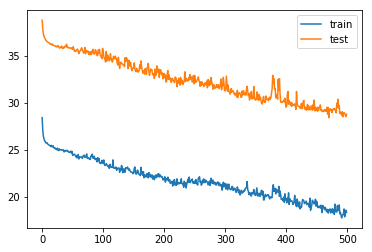

In [64]:
# FITTING #
epochs1 = 500
model,modelstring = create_model(**kwargs_training1)
history1 = model.fit(X_train, y_train, epochs=epochs1, batch_size=30, \
                    validation_data=(X_validate, y_validate), verbose=2, shuffle=False)

#model.save(f"models/{modelstring}_model.h5")  # creates a HDF5 file 
#model.save_weights(f"models/{modelstring}_model_weights.h5")  # creates a HDF5 file 'my_model.h5'

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()

## Model 2

In [66]:
kwargs_training2 = {"momentum":0.0,"decay":0.1,"lr":0.001,"lstm_units":80,
                   "optimizer":"RMSProp","dropout_probability":0.2,"loss_":"mae","learning_rate" :0.001,"rho":0.9,\
                   "epsilon":1e-07,"centered":False,"name":"RMSprop"}

Epoch 1/500
6/6 - 1s - loss: 28.9302 - val_loss: 38.8874
Epoch 2/500
6/6 - 0s - loss: 27.0864 - val_loss: 37.7251
Epoch 3/500
6/6 - 0s - loss: 26.4024 - val_loss: 37.1907
Epoch 4/500
6/6 - 0s - loss: 26.1431 - val_loss: 36.8978
Epoch 5/500
6/6 - 0s - loss: 25.9874 - val_loss: 36.7281
Epoch 6/500
6/6 - 0s - loss: 25.9137 - val_loss: 36.5764
Epoch 7/500
6/6 - 0s - loss: 25.7504 - val_loss: 36.4073
Epoch 8/500
6/6 - 0s - loss: 25.6180 - val_loss: 36.2701
Epoch 9/500
6/6 - 0s - loss: 25.5212 - val_loss: 36.1853
Epoch 10/500
6/6 - 0s - loss: 25.3736 - val_loss: 36.0752
Epoch 11/500
6/6 - 0s - loss: 25.2111 - val_loss: 35.9796
Epoch 12/500
6/6 - 0s - loss: 25.1434 - val_loss: 35.8321
Epoch 13/500
6/6 - 0s - loss: 25.0708 - val_loss: 35.7027
Epoch 14/500
6/6 - 0s - loss: 24.8768 - val_loss: 35.6777
Epoch 15/500
6/6 - 0s - loss: 24.7932 - val_loss: 35.4623
Epoch 16/500
6/6 - 0s - loss: 24.5230 - val_loss: 35.1979
Epoch 17/500
6/6 - 0s - loss: 24.3889 - val_loss: 35.0698
Epoch 18/500
6/6 - 0s -

Epoch 142/500
6/6 - 0s - loss: 17.8300 - val_loss: 27.1980
Epoch 143/500
6/6 - 0s - loss: 18.0523 - val_loss: 27.2271
Epoch 144/500
6/6 - 0s - loss: 18.1866 - val_loss: 26.7633
Epoch 145/500
6/6 - 0s - loss: 17.8026 - val_loss: 27.0112
Epoch 146/500
6/6 - 0s - loss: 17.6963 - val_loss: 27.1233
Epoch 147/500
6/6 - 0s - loss: 17.9548 - val_loss: 27.2335
Epoch 148/500
6/6 - 0s - loss: 17.7738 - val_loss: 27.6359
Epoch 149/500
6/6 - 0s - loss: 17.5738 - val_loss: 26.8616
Epoch 150/500
6/6 - 0s - loss: 17.3785 - val_loss: 27.6652
Epoch 151/500
6/6 - 0s - loss: 17.8365 - val_loss: 26.8403
Epoch 152/500
6/6 - 0s - loss: 17.7035 - val_loss: 26.5583
Epoch 153/500
6/6 - 0s - loss: 17.7302 - val_loss: 26.7658
Epoch 154/500
6/6 - 0s - loss: 17.4396 - val_loss: 26.8531
Epoch 155/500
6/6 - 0s - loss: 17.2377 - val_loss: 26.2515
Epoch 156/500
6/6 - 0s - loss: 17.2693 - val_loss: 26.9031
Epoch 157/500
6/6 - 0s - loss: 17.2750 - val_loss: 26.2790
Epoch 158/500
6/6 - 0s - loss: 17.2506 - val_loss: 26.32

Epoch 281/500
6/6 - 0s - loss: 13.6321 - val_loss: 22.5420
Epoch 282/500
6/6 - 0s - loss: 13.8256 - val_loss: 22.7324
Epoch 283/500
6/6 - 0s - loss: 13.3820 - val_loss: 22.9788
Epoch 284/500
6/6 - 0s - loss: 13.6230 - val_loss: 22.4821
Epoch 285/500
6/6 - 0s - loss: 13.6460 - val_loss: 22.4442
Epoch 286/500
6/6 - 0s - loss: 13.2829 - val_loss: 22.7102
Epoch 287/500
6/6 - 0s - loss: 13.4278 - val_loss: 22.3782
Epoch 288/500
6/6 - 0s - loss: 12.9866 - val_loss: 22.3590
Epoch 289/500
6/6 - 0s - loss: 13.1921 - val_loss: 22.4215
Epoch 290/500
6/6 - 0s - loss: 13.2986 - val_loss: 23.4642
Epoch 291/500
6/6 - 0s - loss: 13.2533 - val_loss: 23.7774
Epoch 292/500
6/6 - 0s - loss: 13.3023 - val_loss: 22.6540
Epoch 293/500
6/6 - 0s - loss: 13.3127 - val_loss: 22.4152
Epoch 294/500
6/6 - 0s - loss: 13.1082 - val_loss: 22.6195
Epoch 295/500
6/6 - 0s - loss: 13.0531 - val_loss: 23.1809
Epoch 296/500
6/6 - 0s - loss: 13.1865 - val_loss: 22.7768
Epoch 297/500
6/6 - 0s - loss: 13.7671 - val_loss: 21.78

Epoch 420/500
6/6 - 0s - loss: 11.2373 - val_loss: 24.4669
Epoch 421/500
6/6 - 0s - loss: 11.9827 - val_loss: 21.1023
Epoch 422/500
6/6 - 0s - loss: 11.4815 - val_loss: 21.0674
Epoch 423/500
6/6 - 0s - loss: 11.5433 - val_loss: 20.6967
Epoch 424/500
6/6 - 0s - loss: 11.7862 - val_loss: 21.3924
Epoch 425/500
6/6 - 0s - loss: 11.3455 - val_loss: 20.6977
Epoch 426/500
6/6 - 0s - loss: 11.6161 - val_loss: 20.6539
Epoch 427/500
6/6 - 0s - loss: 11.2734 - val_loss: 20.9290
Epoch 428/500
6/6 - 0s - loss: 11.4606 - val_loss: 20.8585
Epoch 429/500
6/6 - 0s - loss: 12.9091 - val_loss: 20.8683
Epoch 430/500
6/6 - 0s - loss: 11.2850 - val_loss: 21.0756
Epoch 431/500
6/6 - 0s - loss: 11.6169 - val_loss: 20.6886
Epoch 432/500
6/6 - 0s - loss: 11.2508 - val_loss: 21.3756
Epoch 433/500
6/6 - 0s - loss: 10.9824 - val_loss: 20.9700
Epoch 434/500
6/6 - 0s - loss: 11.3661 - val_loss: 20.3480
Epoch 435/500
6/6 - 0s - loss: 11.0919 - val_loss: 21.2597
Epoch 436/500
6/6 - 0s - loss: 11.3719 - val_loss: 21.58

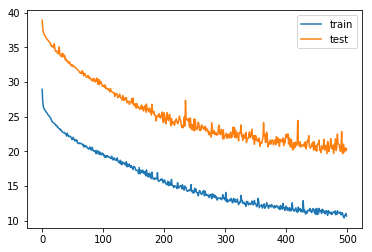

In [67]:
# FITTING #
model,modelstring = create_model(**kwargs_training2)
history2 = model.fit(X_train, y_train, epochs=epochs1, batch_size=30, \
                    validation_data=(X_validate, y_validate), verbose=2, shuffle=False)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()

The model with RMSprop optimizer performs better thus I used it for the prediction.

# Getting final predictions 

In [44]:
testpredictions = np.round(model.predict(X_test, verbose=0),0)